<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/Thompson%20Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you run in jupyter, turn 

```
colab = False
```

In [2]:
colab = True
if colab:
    !pip install control
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/Colab Notebooks/snu/8주_RL/강의자료/실습강의/day5/ts
    !ls

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 9.6 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=4f499228b179898970bb30da52bbdbca6f1135ebec727f957bdbed5b6bbaef14
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Successfully built control
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/snu/8주_RL/강의자료/실습강의/day5/ts
day5_ts.pdf  lq.png  result.png  traj.png  ts.ipynb  utils.py


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Thompson Sampling Practice

In [4]:
import numpy as np
import random
from control import dare, ctrb
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import value_iteration

# 0. Multi-armed Bandit

## 0.0. Define Bandit Agent

For each edge $e$, we have
\begin{gather*}
\log y_e \sim \mathcal{N}\left(\log\theta_e - \frac{\breve \sigma_e^2}{2}, \breve \sigma_e \right).
\end{gather*}
where $\theta_e > 0$ is an uncertain parameter. Hence, we take the prior/poseterior distributions over $\theta_e$ to be lognormal distribution with paramters $\mu_e$ and $\sigma_e$:
\begin{equation*}
\log \theta_e \sim \mathcal{N}(\mu_e, \sigma_e).
\end{equation*}

**[Question]** Where does $\log\theta_e - \frac{\breve \sigma_e^2}{2}$ comes from?

**[Answer]** By setting the mean as above, $y_e$ satisfies $\mathbb{E}[y_e | \theta_e ] = \theta_e$, and accordingly, $\mathbb{E}[y_e] = \mathbb{E}[\theta_e] = \exp\left( \mu_e + \frac{\sigma_e^2}{2}  \right)$!

Therefore, given $\sigma_e$, it is natural to take the prior mean $\mu_e$ to be
\begin{equation*}
\mu_e = \log d_e - \frac{\sigma_e^2}{2},
\end{equation*}
where $d_e$ : rough travel time inferred from the physical distance.

For the details of the problem, see https://arxiv.org/abs/1707.02038.

In [5]:
# Bandit agent
class TSbandit():
    def __init__(self, path_set, dist_edge, s):
        self.path_set = path_set
        self.num_paths = len(path_set)
        self.num_edges = len(dist_edge)
        self.sigma = np.ones(self.num_edges)
        # reasonable choice of prior mean : travel distance
        self.mu = np.log(dist_edge) - .5 * self.sigma ** 2
        self.s = s      # standard deviation of y_t; assumed to be known

    # Bayesian update rule
    def update(self, y_t, e_idx):
        mu_e, sigma_e = self.mu[e_idx], self.sigma[e_idx]
        s = self.s
        # new variance : harmonic mean of two variances
        harmonic = 1. / ((1. / sigma_e ** 2) + (1. / s ** 2)) 
        self.mu[e_idx] = mu_e / (sigma_e ** 2) + (np.log(y_t) + (0.5 * s ** 2)) / (s ** 2)
        self.mu[e_idx] *= harmonic
        self.sigma[e_idx] = np.sqrt(harmonic)
        
        
    def sample(self):
        thetas = []     # set of all \theta_e's sampled from the posterior
        for mu_e, sigma_e in zip(self.mu, self.sigma):
            # key ingredient of Thompson sampling! sample \theta_e's
            th = np.random.lognormal(mu_e, sigma_e)
            thetas.append(th)
        # Get greedy action of sampled models, i.e., \theta_e's.
        # Note that \theta_e = E[y_t | \theta_e].
        # Thus, the shortest path P would be the one with the smallest \sum_P \theta_e.
        rewards = []    # -(mean travel time) of each path according to our model
        for path in self.path_set:
            mean_travel_t = 0.
            for e_idx in path:
                mean_travel_t += thetas[e_idx]
            rewards.append(-mean_travel_t)

        return np.argmax(rewards)

    def greedy(self, epsilon=0):
        thetas = []
        for mu_e, sigma_e in zip(self.mu, self.sigma):
            # Point estimates of \theta_e's of greedy agent.
            th = np.exp(mu_e + .5 * sigma_e ** 2)
            thetas.append(th)
    
        rewards = []
        for path in self.path_set:
            mean_travel_t = 0.
            for e_idx in path:
                mean_travel_t += thetas[e_idx]
            rewards.append(-mean_travel_t)
                         
        # epsilon-greedy
        r = np.random.rand()
        if r < epsilon:
            return np.argmax(rewards)
        else:
            return np.random.randint(self.num_paths)

In [6]:
# Select one of these path to go to destination
path_set = [[0, 5, 10, 14],
            [1, 6, 10, 14],
            [2, 7, 11, 14],
            [2, 7, 12, 15],
            [3, 8, 13, 15],
            [4, 9, 13, 15],
            ]

# Number of edges that construct path jointly
num_edge = 16


num_periods = 1000
num_epochs = 1000

per_period_regret_greedy = np.zeros((num_epochs, num_periods))
per_period_regret_ts = np.zeros((num_epochs, num_periods))

for epoch in tqdm(range(num_epochs)):
    # Generate a problem instance by setting \theta_e's & \breve \sigma.
    # Note that these are true \theta_e's!
    dist_edge = np.random.uniform(2, 5, num_edge)
    sigma_wave = 1.
    theta_edge = dist_edge + np.random.uniform(-0.5, 0.5, num_edge)
    
    true_rewards = []
    for i, path in enumerate(path_set):
            mean_reward_t = 0.
            for e_idx in path:
                mean_reward_t += theta_edge[e_idx]
            true_rewards.append(-mean_reward_t)
    # find the shortest path
    # For larger graphs, more efficient shortest path algorithm may be used.
    shortest_path = np.argmax(true_rewards)
    optimal_reward = np.max(true_rewards)
    
    # Build agent
    agent_greedy = TSbandit(path_set, dist_edge, s=sigma_wave)
    agent_TS = TSbandit(path_set, dist_edge, s=sigma_wave)
    
    # Rollout and calculate regret
    r_greedy, r_TS = [], []
    
    for t in range(num_periods):
        # epsilon-greedy
        a_greedy = agent_greedy.greedy(epsilon=0.5)
        # sampling
        a_ts = agent_TS.sample()
        
        path_greedy = path_set[a_greedy]
        path_ts = path_set[a_ts]
        
        # Rollout and calculate regret
        
        # Realization of travel time observations of each edge.
        # Since edges are pairwise independent, we may sample them simultaneously.
        y = np.random.lognormal(np.log(theta_edge)-.5*(sigma_wave ** 2), sigma_wave)
        
        # Bayesian updates across the paths
        reward_greedy = 0.
        for e_idx in path_greedy:
            y_t = y[e_idx]
            agent_greedy.update(y_t, e_idx)
            reward_greedy -= theta_edge[e_idx]
        
        reward_ts = 0.
        for e_idx in path_ts:
            y_t = y[e_idx]
            agent_TS.update(y_t, e_idx)
            reward_ts -= theta_edge[e_idx]
        
        r_greedy.append(reward_greedy)
        r_TS.append(reward_ts)
        
    # Computation of per-period regrets for all t(broadcasting used).
    per_period_regret_greedy[epoch] = optimal_reward - np.array(r_greedy)
    per_period_regret_ts[epoch] = optimal_reward - np.array(r_TS)

100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]


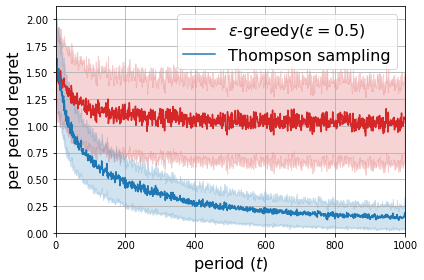

In [7]:
mean_greedy = np.mean(per_period_regret_greedy, axis=0)
std_greedy = np.std(per_period_regret_greedy, axis=0)

mean_ts = np.mean(per_period_regret_ts, axis=0)
std_ts = np.std(per_period_regret_ts, axis=0)

x = np.arange(num_periods)
plt.plot(x, mean_greedy, label=r'$\varepsilon$-greedy($\varepsilon=0.5$)', color='tab:red')
plt.fill_between(x, mean_greedy - .25 * std_greedy, mean_greedy + .25 * std_greedy, alpha=0.2, color='tab:red')
plt.plot(x, mean_ts, label='Thompson sampling', color='tab:blue')
plt.fill_between(x, mean_ts - .25 * std_ts, mean_ts + .25 * std_ts, alpha=0.2, color='tab:blue')

plt.xlim(x[0], x[-1] + 1)
plt.ylim(0.)
plt.legend(fontsize=16)
plt.xlabel(r'period ($t$)', fontsize=16)
plt.ylabel('per period regret', fontsize=16)

plt.grid()
plt.tight_layout()
plt.savefig('result.png')

# 1. Finite Markov Decision Process

In [8]:
class RiverSwimEnv:
    def __init__(self, num_states=6, success_prob=0.8):
        self.num_states = num_states
        self.num_actions = 2
        self.success_prob = success_prob
        self.state = None
        
        P = np.zeros((2 * num_states, num_states))
        R = -np.ones((num_states, 2))
        
        for i in range(num_states):
            P[i, max(0, i - 1)] = 1.
            if i < num_states - 1:
                P[num_states + i, i + 1] = success_prob
                P[num_states + i, i] = 1. - success_prob
            else:
                P[num_states + i, i] = 1.
        R[0, 0] = -0.8
        R[num_states - 1, 1] = 0.
        
        self.R = R
        self.P = P
        
    def reset(self):
        self.state = 2
        return self.state
    
    def step(self, action):
        reward = self.R[self.state, action]
        
        if action == 0:
            self.state = max(self.state - 1, 0)
        elif action == 1:
            if np.random.rand() < self.success_prob:
                self.state = min(self.state + 1, self.num_states - 1)
        
        return self.state, reward
    
    @property
    def R_true(self):
        return self.R
    
    @property
    def P_true(self):
        return self.P

In [9]:
class TSRLAgent:
    def __init__(self, num_states, num_actions, alpha0, R):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha0    # parameters for Dirichlet priors & posteriors
        self.R = R
        self.policy = None
        
    def reset(self):
        P = self.infer_model()
        self.policy = value_iteration(P=P, R=self.R)[1]
        
    def act(self, state):
        return self.policy[state]
    
    def update(self, state, action, next_state):
        self.alpha[self.num_states * action + state, next_state] += 1
        
    def infer_model(self):
        nrows = self.num_states * self.num_actions
        P = np.zeros((nrows, self.num_states))
        for i in range(nrows):
            P[i] = np.random.dirichlet(self.alpha[i])
        return P

In [10]:
def TSRL(env, max_t=10000, verbose=True):
    num_states = env.num_states
    num_actions = env.num_actions
    alpha0 = .1 * np.ones((num_states * num_actions, num_states))
    agent = TSRLAgent(num_states=num_states, num_actions=num_actions, alpha0=alpha0, R=env.R_true)
    t = 0
    t_init = 0
    ep_len = 1
    cumul_reward = 0.
    reward_arr = []
    visit_count = np.zeros((num_states, num_actions), dtype=int)
    state = env.reset()
    while True:
        agent.reset()
        visit_count_init = visit_count
        while t <= t_init + ep_len:
            action = agent.act(state)
            next_state, reward = env.step(action)
            visit_count[state, action] += 1
            
            cumul_reward += reward
            reward_arr.append(cumul_reward)

            # TODO : find update function and give appropriate arguments
            agent.update(state, action, next_state)
            state = next_state
            
            if visit_count[state, action] > 2 * visit_count_init[state, action]:
                break
            
            t += 1
            if verbose and t % 5000 == 0:
                print('{} steps completed'.format(t))
            
            if t >= max_t:
                break
        if t >= max_t:
            break
        ep_len = t - t_init
        t_init = t
        
    return agent, reward_arr

In [11]:
env = RiverSwimEnv(num_states=10, success_prob=0.5)
print('transition probability :', env.P_true)
print('reward :', env.R_true)

transition probability : [[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]
reward : [[-0.8 -1. ]
 [-1.  -1. ]
 [-1.  -1. ]
 [-1.  -1. ]
 [-1.  -1. ]
 [-1.  -1. ]
 [-1.  -1. ]
 [-1.  -1. ]
 

In [12]:
T = 200000

agent, reward_arr = TSRL(env=env, max_t=T)

5000 steps completed
10000 steps completed
15000 steps completed
20000 steps completed
25000 steps completed
30000 steps completed
35000 steps completed
40000 steps completed
45000 steps completed
50000 steps completed
55000 steps completed
60000 steps completed
65000 steps completed
70000 steps completed
75000 steps completed
80000 steps completed
85000 steps completed
90000 steps completed
95000 steps completed
100000 steps completed
105000 steps completed
110000 steps completed
115000 steps completed
120000 steps completed
125000 steps completed
130000 steps completed
135000 steps completed
140000 steps completed
145000 steps completed
150000 steps completed
155000 steps completed
160000 steps completed
165000 steps completed
170000 steps completed
175000 steps completed
180000 steps completed
185000 steps completed
190000 steps completed
195000 steps completed
200000 steps completed


In [13]:
gain, pi_opt = value_iteration(env.P_true, env.R_true)
print('optimal policy :', pi_opt)

optimal policy : [1 1 1 1 1 1 1 1 1 1]


In [14]:
num_trials = 50
T = 50000

regrets = np.zeros((num_trials, T))

for i in tqdm(range(num_trials)):
    reward_arr = TSRL(env=env, max_t=T, verbose=False)[1]
    regrets[i] = gain * np.arange(1, T + 1) - np.array(reward_arr)

100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


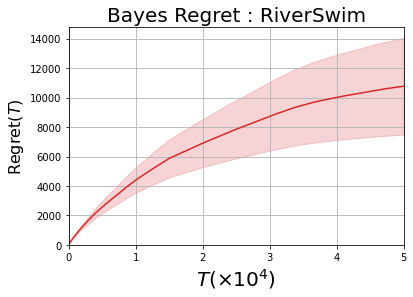

In [15]:
mean_regret = np.mean(regrets, axis=0)
std_regret = np.std(regrets, axis=0)

xscale = -4
unit_sz = 10 ** xscale
x = unit_sz * np.arange(T)

plt.plot(x, mean_regret, color='tab:red')
plt.fill_between(x, mean_regret - .25 * std_regret, mean_regret + .25 * std_regret, alpha=0.2, color='tab:red')
plt.xlabel(r'$T (\times 10^{})$'.format(-xscale), fontsize=20)
plt.ylabel(r'Regret$(T)$', fontsize=16)
plt.title('Bayes Regret : RiverSwim', fontsize=20)
plt.xlim(0, unit_sz * T)
plt.ylim(0)
plt.grid()
# plt.tight_layout()
# plt.savefig('riverswim.png', dpi=1080)

# 2. Linear Quadratic Control

In [16]:
def compute_gain(theta, Q, R):
    # Compute the gain matrix G of LQ system (A, B, Q, R).
    n = Q.shape[0]
    m = R.shape[0]
    assert theta.shape == (n + m, n)
    A = theta[:n].T
    B = theta[n:].T
    G = -dare(A, B, Q, R)[2]
    return np.asarray(G)

In [17]:
class LinearSystem:
    def __init__(self, A, B, x0=None):
        self.A = A
        self.B = B
        self.n = B.shape[0]
        self.m = B.shape[1]
        
        if x0 is None:
            self.x0 = np.zeros(self.n)
        else:
            self.x0 = x0
        
    def reset(self):
        self.x = np.copy(self.x0)
        return np.copy(self.x)
    
    def step(self, u):
        # x_t+1 = A x_t + B u_t + w_t, w_t ~ N(0, I_n)
        # TODO : complete above equation implementation
        #self.x = self.A @ self.x + [TODO] + np.random.randn([TODO])
        self.x = self.A @ self.x + self.B @ u + np.random.randn(self.n)
        return np.copy(self.x)
    
    def is_stable(self, G: np.ndarray, delta) -> bool:
        # Determine if an input controller is \delta-stable.
        # assert delta < 1.
        assert G.shape == (self.m, self.n)
        norm = np.linalg.norm(self.A + self.B @ G, ord=2)
        return True if norm <= delta else False

In [18]:
class Distribution:
    def __init__(self, system: LinearSystem, Q, R, mean_prior=None, cov_prior=None):
        self.system = system
        self.Q = Q
        self.R = R
        self.n = Q.shape[0]
        self.m = R.shape[0]
        
        d = self.n + self.m
        
        # location & scale parameters
        if mean_prior is None:
            self.mean = np.zeros((d, self.n))
        else:
            self.mean = mean_prior
        if cov_prior is None:
            self.cov = np.eye(d)
        else:
            self.cov = cov_prior

        
    def sample(self, delta):
        L = np.linalg.cholesky(self.cov)
        d, n = self.mean.shape
        # rejection sampling
        accept = False
        while not accept:
            theta = self.mean + L @ np.random.randn(d, n)
            G = compute_gain(theta, self.Q, self.R)
            accept = self.system.is_stable(G, delta)
        return theta
    
    def update(self, z, x_next):
        # Bayesian update of parameters
        # z = (x_1, ..., x_n, u_1, ..., u_m)
        cov_times_z = self.cov @ z
        denom = 1 + np.dot(z, cov_times_z)
        self.mean += np.outer(cov_times_z, x_next - z @ self.mean) / denom
        self.cov -= np.outer(cov_times_z, cov_times_z) / denom
        return
    
    @property
    def cov_sz(self):
        return np.prod(np.linalg.eigvals(self.cov))

In [19]:
def PSRL_LQ(system: LinearSystem, Q, R, mean_prior=None, cov_prior=None, delta=0.999, max_t=10000, verbose=True):
    distribution = Distribution(system, Q=Q, R=R, mean_prior=mean_prior, cov_prior=cov_prior)
    
    cost_arr = []
    state_arr = []
    cost = 0.
    t = 0
    t_init = 0
    ep_len = 1
    x = system.reset()
    while True:
        theta = distribution.sample(delta=delta)
        G = compute_gain(theta, Q, R)
        init_cov_sz = distribution.cov_sz
        current_cov_sz = init_cov_sz
        while (t <= t_init + ep_len) and (current_cov_sz >= 0.5 * init_cov_sz):
            
            u = G @ x
            state_arr.append(x)
            cost += np.dot(x, Q @ x) + np.dot(u, R @ u)
            cost_arr.append(cost)
            z = np.concatenate([x, u])
            x_next = system.step(u)
            distribution.update(z=z, x_next=x_next)
            x = x_next
            t += 1
            if verbose and t % 1000 == 0:
                print('{} steps completed'.format(t))
            
            if t >= max_t:
                break
        if t >= max_t:
            break
        ep_len = t - t_init
        t_init = t
        
    return theta, cost_arr, state_arr

# Experiment

In [20]:
n, m = 3, 2

h = 0.1
A2 = np.array([
    [1., 0., -h ** 2],
    [0., 1., h ** 2],
    [0., 0., 1.]
])

B2 = np.array([
    [h / np.sqrt(2.), 0.],
    [h / np.sqrt(2.), 0.],
    [0., 1.]
])
x0 = np.array([0., 200., 0.])

# check controllability
C = ctrb(A2, B2)
assert np.linalg.matrix_rank(C) == 3

Q2 = np.diag([1., 1., .5])
R2 = 0.1 * np.eye(2)

theta2 = np.hstack([A2, B2]).T
# set mean prior
# encoding domain knowledge is possible!
mu0 = theta2 + 0.3 * np.random.rand()
mu0 = 0.5 * np.ones((n + m, n))
# sigma0 = .01 * np.eye(n + m)

In [21]:
car_system = LinearSystem(A=A2, B=B2, x0=x0)
optimal_cost = np.trace(dare(A2, B2, Q2, R2)[0])

T = 2000

theta, c_arr, s_arr = PSRL_LQ(car_system, Q=Q2, R=R2, mean_prior=mu0, delta=1.5, max_t=T)
regrets = np.array(c_arr) - optimal_cost * np.arange(1, T + 1)
thetas = theta
states = np.array(s_arr)

1000 steps completed
2000 steps completed


In [22]:
x_ref = np.vstack([h * np.arange(T), h * np.arange(T), (np.pi / 4.) * np.ones(T)]).T
x = states + x_ref
x1 = x[:, 0]
x2 = x[:, 1]

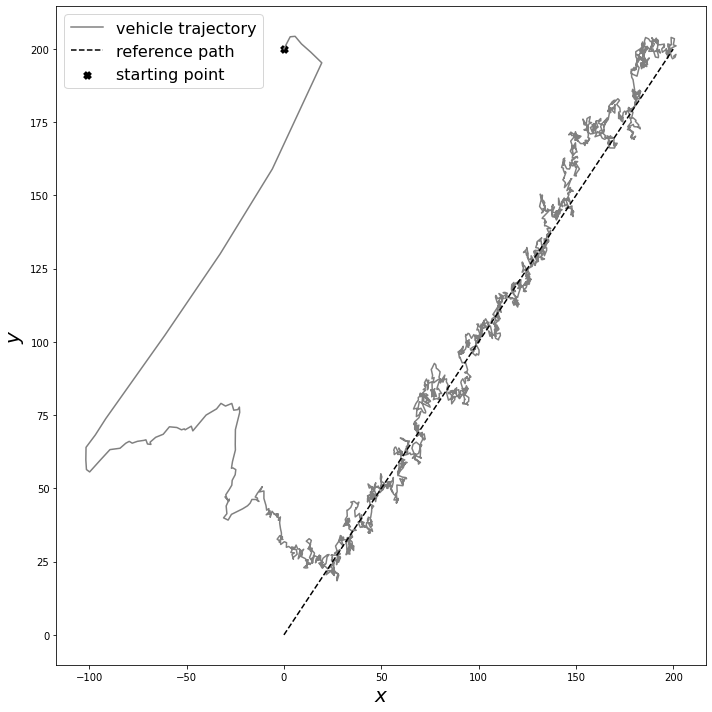

In [23]:
plt.figure(figsize=(10, 10))
plt.scatter(x0[0], x0[1], marker='x', label='starting point', color='black', linewidth=4)
plt.plot(x1, x2, color='gray', label='vehicle trajectory')
plt.plot(x_ref[:, 0], x_ref[:, 1], linestyle='dashed', color='black', label='reference path')
plt.legend(fontsize=16)
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.tight_layout()
plt.savefig('traj.png', dpi=1080)

# Let's check how the regret goes!

In [24]:
num_trials = 50
T = 2000

regrets = np.zeros((num_trials, T))

for i in tqdm(range(num_trials)):
    c_arr = PSRL_LQ(car_system, Q=Q2, R=R2, mean_prior=mu0, delta=1.5, max_t=T, verbose=False)[1]
    regrets[i] = np.array(c_arr) - optimal_cost * np.arange(1, T + 1)

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


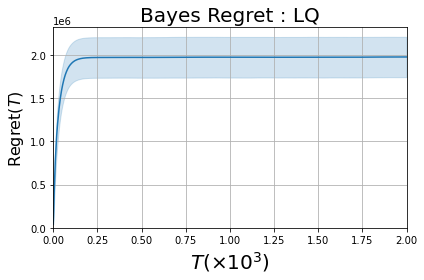

In [25]:
mean_regret = np.mean(regrets, axis=0)
std_regret = np.std(regrets, axis=0)

xscale = -3
unit_sz = 10 ** xscale
x = unit_sz * np.arange(T)

plt.plot(x, mean_regret, color='tab:blue')
plt.fill_between(x, mean_regret - .5 * std_regret, mean_regret + .5 * std_regret, alpha=0.2, color='tab:blue')
plt.xlabel(r'$T (\times 10^{})$'.format(-xscale), fontsize=20)
plt.ylabel(r'Regret$(T)$', fontsize=16)
plt.title('Bayes Regret : LQ', fontsize=20)
plt.xlim(0, unit_sz * T)
plt.ylim(0)
plt.grid()
plt.tight_layout()
plt.savefig('lq.png', dpi=1080)